In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import sys

parent_dir = str(Path().resolve().parents[0])
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [2]:
from sklearn.datasets import make_moons, make_classification

from jax import vmap
from functools import partial
import matplotlib.colors as mplcolors

def alpha_scaler(x, T, thresh):
    return (x - thresh) / (np.max(T) - thresh)

@partial(vmap, in_axes=(0, None, None))
def minmax_scaler(x, max_val, min_val):
    return ((x - min_val) / (max_val - min_val)).round(5)

def grey_cmap(alpha):

    rgba = list(mplcolors.to_rgba('grey'))
    rgba[-1] = alpha

    return rgba

# @partial(vmap, in_axes=(0, None))
def rotate_around_origin(pt, angle_in_rad):
    x, y = pt
    c, s = np.cos(angle_in_rad), np.sin(angle_in_rad)
    j = np.matrix([[c, s], [-s, c]])
    m = np.dot(j, [x, y])
    return m

def get_super_xlimits(axs, func=max):
    return func([ax.get_xlim() for ax in axs])

def get_super_ylimits(axs, func=max):
    return func([ax.get_ylim() for ax in axs])

In [3]:
n = 500
m = 500

target_rot = -20
source_labels = 0.9
target_labels = 0.2

gamma = 1e-2
gamma_r = 1e-2
gamma_c = 1e-2

num_iters = int(5e4)

colors = np.array(['blue', 'red', 'grey'])

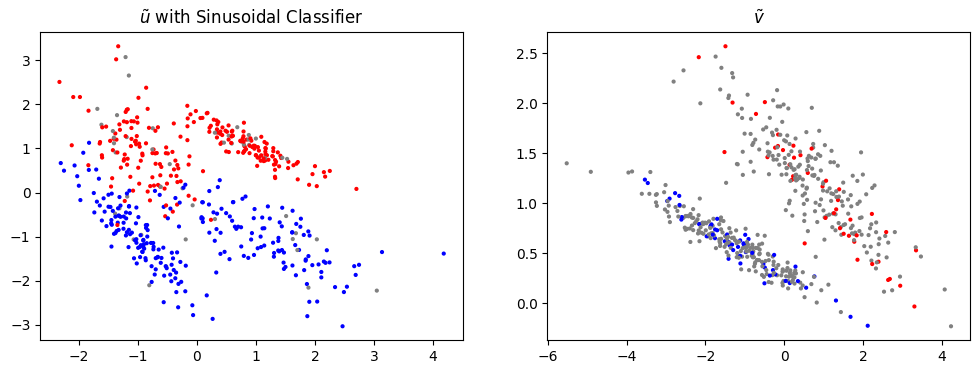

In [4]:
# make source dataset
X, y = make_classification(n, n_features=2, n_redundant=0, n_informative=2, random_state=1, n_classes=2, n_clusters_per_class=2)
# X, y = make_moons(n, noise=0.1, random_state=1)
# perturb labels to have some unknown data
unlabelled_mask = np.where(np.random.random(n) >= source_labels)[0]
y[unlabelled_mask] = 2

# make target dataset
X_tar, y_tar = make_classification(n, n_features=2, n_redundant=0, n_informative=2, random_state=2, n_classes=2, n_clusters_per_class=1)
# X_tar, y_tar = make_moons(m, noise=0.1, random_state=2)
X_tar = np.array([rotate_around_origin(pt, target_rot*np.pi/180) for pt in X_tar]).squeeze()
# perturb labels to have some unknown data
unlabelled_mask = np.where(np.random.random(m) >= target_labels)[0]
y_tar[unlabelled_mask] = 2

# plotting
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].set_title(r'$\tilde{u}$'+' with Sinusoidal Classifier')
axs[0].scatter(*X.T, color=colors[y], s=4)

axs[1].set_title(r'$\tilde{v}$')
axs[1].scatter(*X_tar.T, color=colors[y_tar], s=4)

# for ax in axs:
#     ax.set_xlim((get_super_xlimits(axs, min)[0], get_super_xlimits(axs, max)[-1]))
#     ax.set_ylim((get_super_ylimits(axs, min)[0], get_super_ylimits(axs, max)[-1]))

# plot_x = np.linspace(-2, 3)
# axs[0].plot(plot_x, 0.25+0.45*np.sin(3*(plot_x+0.5)), c='k', linestyle='dashed', label='Classifier')
# axs[0].plot(plot_x, 0.25+(0.45+0.1*np.abs(plot_x)**2)*np.sin(3*(plot_x+0.5)), c='k', linestyle='dashed', label='Classifier')


(500, 2) (500,) (500, 1)
(500, 2) (500,) (1, 500)


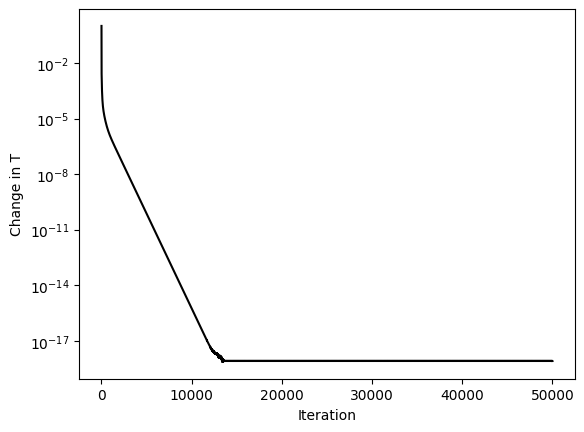

In [5]:
from src.utils.solvers import SoftBregman, LogStabilised_SoftBregman

rows_to_relax = (y == 2).reshape(-1, 1)
cols_to_relax = (y_tar == 2).reshape(1, -1)

l_idxs = np.where(np.logical_and(
    np.tile(y, (m, 1)).T != np.tile(y_tar, (n, 1)),
    np.logical_and(np.tile(y, (m, 1)).T < 2, np.tile(y_tar, (n, 1)) < 2),
))
blocked_idxs = zip(*l_idxs)

mu = np.ones(n)
nu = np.ones(m)

def C(x, y):
    return (np.abs(x - y) ** 2).sum(axis=-1)

print(X.shape, mu.shape, rows_to_relax.shape)
print(X_tar.shape, nu.shape, cols_to_relax.shape)

solver = SoftBregman(gamma, gamma_c, gamma_r, rows_to_relax, cols_to_relax, blocked_idxs)
T = solver.solve(X, X_tar, mu, nu, C=C(X[:, None], X_tar[None, :]), plot=True, num_iters=num_iters)

# TODO: troubleshoot this log solver, isn't producing valid plans.
# solver = LogStabilised_SoftBregman(gamma, gamma_c, gamma_r, rows_to_relax, cols_to_relax, blocked_idxs)
# T = solver.solve(X, X_tar, mu, nu, C=C(X[:, None], X_tar[None, :]), plot=True, num_iters=num_iters)

In [6]:
T

array([[2.21045437e-05, 5.71239994e-05, 8.22479653e-03, ...,
        8.60116944e-03, 9.08988798e-03, 6.44956667e-04],
       [7.34354111e-04, 1.53781553e-03, 6.94180447e-07, ...,
        6.49764689e-07, 3.62386137e-06, 4.34387028e-03],
       [4.43376581e-03, 3.94986353e-03, 3.43926851e-03, ...,
        2.98905591e-03, 1.07016081e-03, 1.82899351e-03],
       ...,
       [7.32684741e-09, 7.34772874e-08, 6.19758876e-06, ...,
        7.84329672e-06, 1.02086118e-04, 3.06976170e-05],
       [8.19973457e-07, 3.62041485e-06, 1.83980684e-03, ...,
        2.09412804e-03, 4.70805148e-03, 1.87207632e-04],
       [4.43800104e-03, 5.54438864e-03, 1.92411446e-05, ...,
        1.69448327e-05, 2.70230472e-05, 4.45685179e-03]], shape=(500, 500))

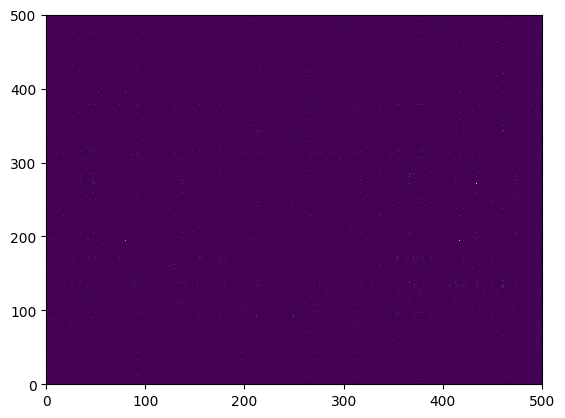

In [7]:
plt.pcolormesh(T)

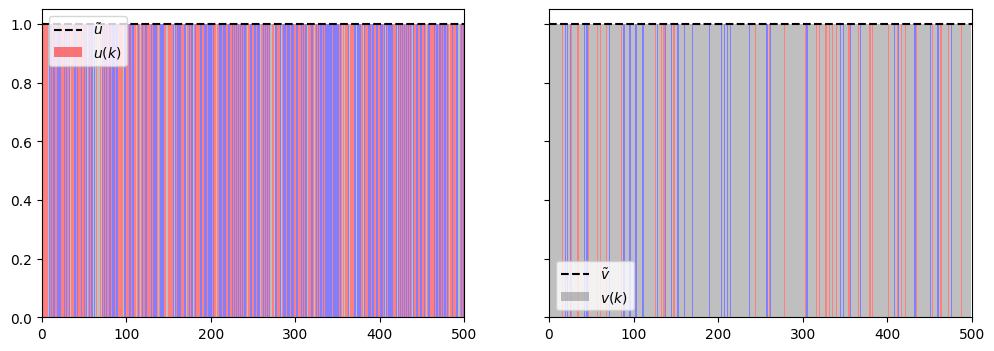

In [8]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey='row')

axs[0].bar(x=range(len(X)), height=np.sum(T, axis=1), width=1, color=colors[y], alpha=0.5, label=r'$u(k)$')
axs[1].bar(x=range(len(X_tar)), height=np.sum(T, axis=0), width=1, color=colors[y_tar], alpha=0.5, label=r'$v(k)$')

axs[0].hlines(y=mu[0], xmin=0, xmax=n, linestyle='dashed', color='k', label=r'$\tilde{u}$')
axs[1].hlines(y=nu[0], xmin=0, xmax=m, linestyle='dashed', color='k', label=r'$\tilde{v}$')

axs[0].set_xlim(0, n)
axs[1].set_xlim(0, m)

axs[0].legend(loc='upper left')
axs[1].legend(loc='lower left')

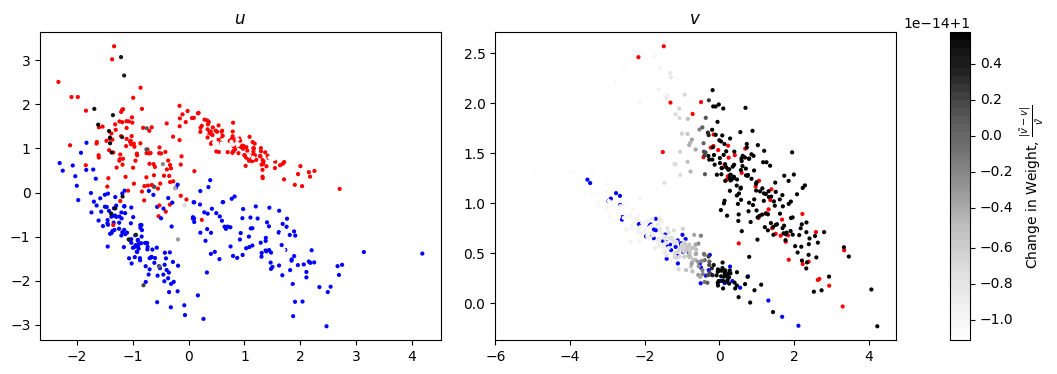

In [9]:
import matplotlib as mpl

weights_0 = np.sum(T, axis=1) / mu
weights_1 = np.sum(T, axis=0) / nu

scale_min, scale_max = np.min([np.min(weights_0), np.min(weights_1)]), np.max([np.max(weights_0), np.max(weights_1)])
# scale_max = max(2.0, scale_max)
# scale_min = min(0.0, scale_min)

cmap = 'Greys'
norm = mplcolors.Normalize(vmin=scale_min, vmax=scale_max)

fig, axs = plt.subplots(1, 3, figsize=(12,4), dpi=100, width_ratios=[1,1,0.05])

axs[0].scatter(*X[y != 2].T, color=colors[y[y != 2]], s=4)
axs[0].scatter(*X[y == 2].T, color=mpl.colormaps[cmap](norm(weights_0[y == 2])), s=4)
axs[0].set_title('$u$')

axs[1].scatter(*X_tar[y_tar != 2].T, color=colors[y_tar[y_tar != 2]], s=4)
axs[1].scatter(*X_tar[y_tar == 2].T, color=mpl.colormaps[cmap](norm(weights_1[y_tar == 2])), s=4)
axs[1].set_title('$v$')

from matplotlib.cm import ScalarMappable
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), cax=axs[-1], label=r'Change in Weight, $\frac{| \tilde{v} - v |}{\tilde{v}}$')

axs = axs[:-1]
# for ax in axs:
#     ax.set_xlim((get_super_xlimits(axs, min)[0], get_super_xlimits(axs, max)[-1]))
#     ax.set_ylim((get_super_ylimits(axs, min)[0], get_super_ylimits(axs, max)[-1]))

# Plans

 - plot v again but with the colour of the space it's transported to

In [10]:
def compute_Xs(X_t, T, labels=None):
    n, m = T.shape
    _, d = X_t.shape
    
    T_sum = np.sum(T, axis=1)
    T_sum[T_sum == 0] = 1e-12
    normalization = T / T_sum[:, None]  # broadcasting over rows
    
    # Finally multiply by X_t
    X_s = normalization @ X_t  # shape (n, d)

    if labels is not None:
        y_s = normalization @ labels
        return X_s, y_s
        
    return X_s

In [11]:
def rgba_interpolate(k, colors, x=2):
    if k == x:
        return colors[1]
    
    elif k < x:
        return (k/x) * colors[1] + (1 - k/x) * colors[0]
    
    else:
        return ((k-x)/x) * colors[2] + (1 - (k-x)/x) * colors[1]

def transport_twoclass_labels(X, T, labels, colors=['blue', 'red', 'grey']):
    labels[labels == 1] = 4 # spread out the classes either side of the neutral label
    colors = colors[[0, 2, 1]] # reorder colors to reflect this
    rgba_colors = mplcolors.to_rgba_array(colors)

    # X_T, y_T = compute_Xs(X, T, labels=labels)
    X_T = T @ X
    y_T = (T / np.sum(T, axis=1, keepdims=True)) @ labels

    colors_T = np.array([rgba_interpolate(y, rgba_colors) for y in y_T])
    colors_T[:, -1] = (norm(np.sum(T, axis=1)))

    return X_T, colors_T


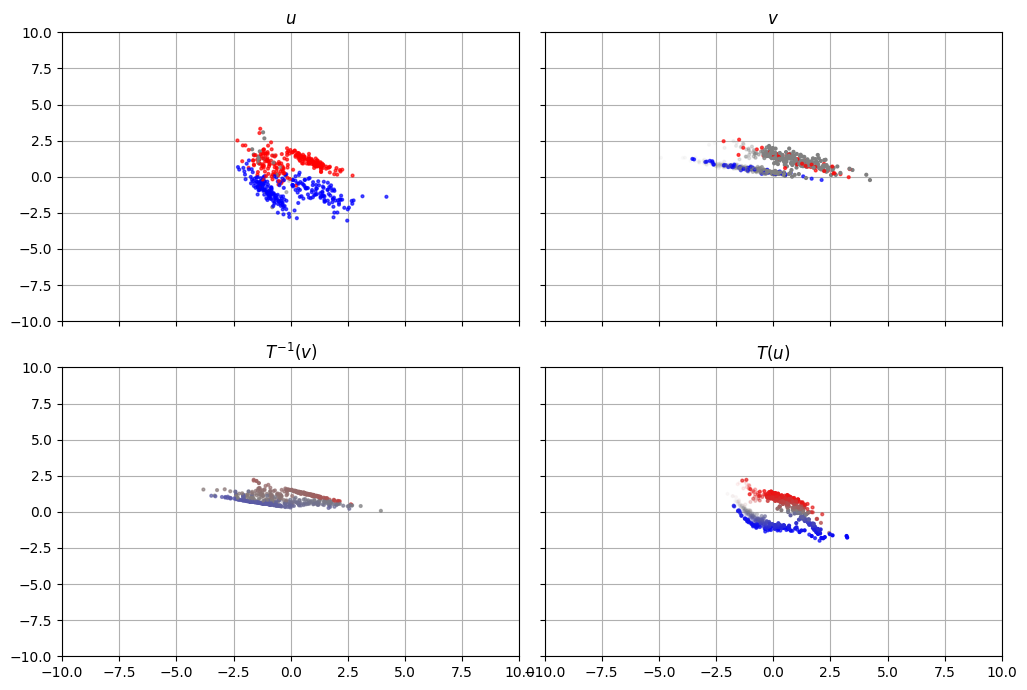

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10,7), dpi=100, sharex='all', sharey='all')

rgba_colors = mplcolors.to_rgba_array(colors)

# source
colors_s = np.array([rgba_interpolate(label, rgba_colors, x=1) for label in y])
colors_s[:, -1] = (norm(np.sum(T, axis=1)))
axs[0, 0].scatter(*X.T, color=colors_s, s=4)
axs[0, 0].set_title('$u$')

# transported target
X_tar_T, colors_T = transport_twoclass_labels(X_tar, T, y_tar.copy(), colors=colors)
axs[1, 0].scatter(*X_tar_T.T, color=colors_T, s=4)
axs[1, 0].set_title('$T^{-1}(v)$')

# target
colors_tar = np.array([rgba_interpolate(label, rgba_colors, x=1) for label in y_tar])
colors_tar[:, -1] = (norm(np.sum(T, axis=0)))
axs[0, 1].scatter(*X_tar.T, color=colors_tar, s=4)
axs[0, 1].set_title('$v$')

# transported source
X_T, colors_T = transport_twoclass_labels(X, T.T, y.copy(), colors=colors)
axs[1, 1].scatter(*X_T.T, color=colors_T, s=4)
axs[1, 1].set_title('$T(u)$')

fig.tight_layout()

axs[0,0].set_xlim(-10, 10)
axs[0,0].set_ylim(-10, 10)

for ax in axs.flatten():
    ax.grid()
    ax.set_axisbelow(True)
#     ax.plot(plot_x, 0.25+0.45*np.sin(3*(plot_x+0.5)), c='k', linestyle='dashed', label='Classifier', lw=1)